# Предварительная настройка

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [56]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import sys
import copy
import random
import json

In [7]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

# Датасет

**image loaders** https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**data loaders** https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [67]:
NAME='Fires'

NAME='Fast Food Classification V2'

In [68]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/My Drive/AI/Samsung/'+NAME

data_dir = './'+NAME
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


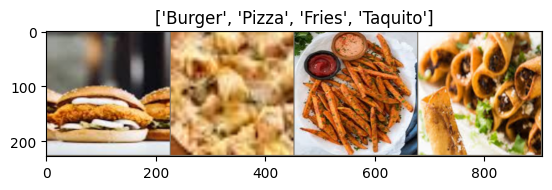

In [70]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [71]:
class_names
# for inputs, labels in dataloaders['train']:
#      print(labels)

['Baked Potato',
 'Burger',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Pizza',
 'Sandwich',
 'Taco',
 'Taquito']

In [72]:
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

In [77]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = [];
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                # scheduler.step()
                scheduler.step(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc)
            else:
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    model.eval()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))

    plt.plot(np.arange(0,num_epochs),hist_loss_train,label='hist_loss_train')
    plt.plot(np.arange(0,num_epochs),hist_loss_val,label='hist_loss_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Loss')
    plt.show()
    plt.plot(np.arange(0,num_epochs),hist_acc_train,label='hist_acc_train')
    plt.plot(np.arange(0,num_epochs),hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [74]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ReduceLROnPlateau, который снижает скорость обучения, если метрика валидации не улучшается. было StepLR

In [75]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# !!!!!!!!!!!!!!!!!!!!!!!!! Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, mode='min', factor=0.1, patience=5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/drmr/Documents/Миша/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/drmr/Documents/Миша/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/59
----------


/home/drmr/Documents/Миша/venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/Documents/Миша/venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


UnboundLocalError: local variable 'epoch_loss' referenced before assignment

Время инфренса батча(мс): 145.531654


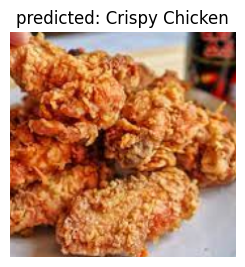

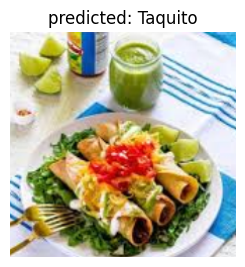

In [ ]:
visualize_model(model_ft.to(device),num_images=2)

[[307   1  29   1   2   5  28   1  16  10]
 [  5 256   6   3   1  10   0  15   2   2]
 [  7  11 355   1   6   1   3   4   4   8]
 [  3   2   3 270   2   8   2   1   4   5]
 [  4  14  13   7 315  17   2   1  19   8]
 [ 11   8  14   3  15 180   6   9  28  26]
 [  5   0  10   1   3   4 258   5   7   7]
 [  7  20   7   3  20  19   4 179  21  20]
 [ 16   2  13   4   6  17   4   3 318  17]
 [ 13   3  25  11  17  21  15   7  47 241]]


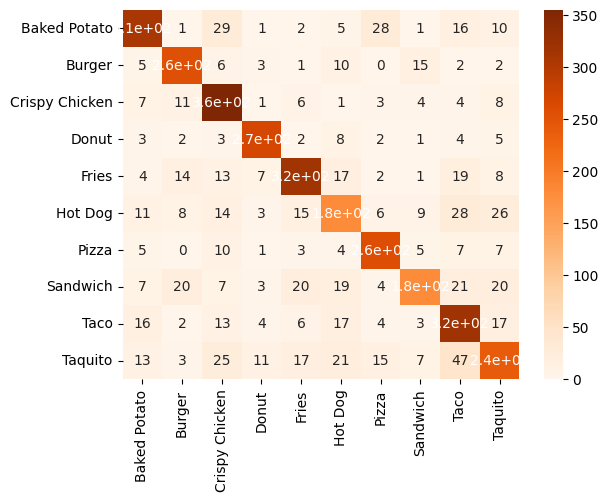

In [ ]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['val']:
  pred = model_ft.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [ ]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model_ft.eval()
model_ft=model_ft.to(torch.device("cpu"))
#model_ft=torch.quantization.convert(model_ft)
#torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
# script_model.save("/content/drive/My Drive/AI/Samsung/"+NAME+".pt")
script_model.save("./"+NAME+"_v2.pt")

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [62]:
# Функция для предсказания и отображения одного изображения из папки 'test'
def predict_and_show_image(model, image_path, class_names, device):
    # Преобразование изображения
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Загрузка изображения
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
    
    # Отображение изображения с предсказанием
    plt.figure()
    imshow(image_tensor.cpu().squeeze(), f'Predicted: {class_names[preds[0]]}')
    plt.show()

In [63]:
# Загрузка классов из файла
with open('class_names.json', 'r') as f:
    class_names = json.load(f)

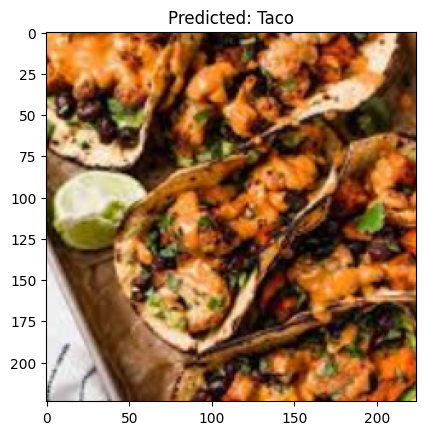

In [65]:
model_path = f"./{NAME}.pt"
model_ft = torch.jit.load(model_path)
model_ft.eval()
model_ft = model_ft.to(device)

# Задайте путь к изображению из папки 'test'
image_path = f'./{NAME}/test/Taco/Taco-Test (1).jpeg'

# Вызов функции для предсказания и отображения изображения
predict_and_show_image(model_ft, image_path, class_names, device)

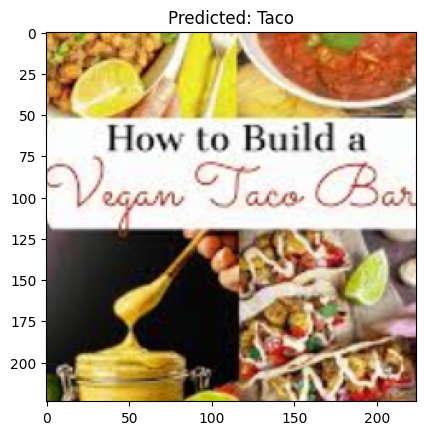

In [66]:
# Задайте путь к изображению из папки 'test'
image_path = f'./{NAME}/test/Taco/Taco-Test (9).jpeg'

# Вызов функции для предсказания и отображения изображения
predict_and_show_image(model_ft, image_path, class_names, device)

In [ ]:
# Задайте путь к изображению из папки 'test'
image_path = f'./{NAME}/test/Taco/Taco-Test (9).jpeg'

# Вызов функции для предсказания и отображения изображения
predict_and_show_image(model_ft, image_path, class_names, device)